# 변수명 안내
- total_data : 수집된 키워드별 리뷰 데이터
- stopwords : 불용어 집합 변수
- threshold : 최소 빈도수 값 정의

In [1]:
!pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=5079c1707d019956257e8754e550e27d8ffa2529dc3506c945bd04ecca4729db
  Stored in directory: c:\users\cgi\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
  Created wheel for wrapt: filename=wrapt-1.12.1-py3-none-any.whl size=19558 sha256=295bd5d40b983a43107d27baae902552e9619d717d6c1a1066a90a601198914f
  Stored in directory: c:\users\cgi\appdata\local\pip\cache\wheels\5f\fd\9e\b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
Successfully built termcolor wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.11.2
    Uninstalling wrapt-1.11.2:
      Successfully uninstalled wrapt-1.11.2
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0


In [3]:
!pip install konlpy

  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.9.3
    Uninstalling beautifulsoup4-4.9.3:
      Successfully uninstalled beautifulsoup4-4.9.3


In [4]:
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 데이터 로드

In [2]:
total_data = pd.read_csv(
    #'./ReviewDataSet/Lodgment_Integrated.csv', ###SNS에서 수집한 데이터(라벨링 된) 로드
    encoding='CP949'
)

#데이터 value의 수 확인
print(len(total_data))

386677


In [3]:
#10개 value 확인
total_data[:10]

,document,label
0,숙소 깨끗햇어요~ 근데 로비만 잘되어있구 방은 방음도 안되고.. 이불은 무슨 담요보...,0
1,카페같은 느낌이라 좋앗어요~ 그리고 코스랑 맛집이랑 버스번호 스크랩해놓은 북이 도움...,0
2,방음이 전혀 안돼요. 일상대화도 (완전신경쓰임)못 나눌만큼 심하네요\n가족.지인 단...,0
3,1인실 사용했는데 그나마 넓어서 좋았어요 침대 사이 간격이 넘 좁아서 침대로 들어갈...,0
4,"신축이라서 깔끔 근데내가 게스트하우스를 온건지 어딜 온건지,, 너무 많은 주의사항에...",0
5,방은 깔끔하고 사장님 친절하세요\n그런데 친구들끼리 가는 것보다는 혼자 여행갈때 머...,0
6,사장님 너무 친절하셨고 시설 다 깔끔해서 좋았어요! 근데 침대가 진짜 ... 처음 ...,0
7,너무 깨끗하고 사장님도 친절하시고 다 너무너무 좋았는데 방음이 전.혀. 안되네요.....,0
8,"게하의 관리가 꼼꼼하고 주인장이 엄청친절합니다. 군더더기없이 깨끗하고좋으나, 방음...",0
9,친절한 설명과 깔끔한 방까지 좋았습니다. 근데 화장실 하수구 냄새가 너무 심했어요ㅠ...,0


## 중복 및 결측치 처리
- 데이터 개수 확인
- 데이터에 중복이 존재한다면 이를 제거

In [4]:
#유니크한 value의 개수 확인
print(total_data['document'].nunique())
print(total_data['label'].nunique())

# 중복 제거
total_data.drop_duplicates(subset=['document'], inplace=True)

36147
2


In [5]:
#결측치 개수 확인
print(total_data.isnull().sum())

# 결측치 제거
total_data = total_data.dropna(how='any')

document    0
label       0
dtype: int64


## 데이터 정제
- 데이터에서 한글과 공백을 제외하고 모두 제거

In [6]:
# replace 에 포함된 나머지 문자들 제거
total_data['document'] = total_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

total_data[:10]

C:\Users\CGI\anaconda3\envs\test2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,document,label
0,숙소 깨끗햇어요 근데 로비만 잘되어있구 방은 방음도 안되고 이불은 무슨 담요보다 얇...,0
1,카페같은 느낌이라 좋앗어요 그리고 코스랑 맛집이랑 버스번호 스크랩해놓은 북이 도움이...,0
2,방음이 전혀 안돼요 일상대화도 완전신경쓰임못 나눌만큼 심하네요가족지인 단체로는 비추...,0
3,인실 사용했는데 그나마 넓어서 좋았어요 침대 사이 간격이 넘 좁아서 침대로 들어갈때...,0
4,신축이라서 깔끔 근데내가 게스트하우스를 온건지 어딜 온건지 너무 많은 주의사항에 피...,0
5,방은 깔끔하고 사장님 친절하세요그런데 친구들끼리 가는 것보다는 혼자 여행갈때 머무는...,0
6,사장님 너무 친절하셨고 시설 다 깔끔해서 좋았어요 근데 침대가 진짜 처음 느껴보는...,0
7,너무 깨끗하고 사장님도 친절하시고 다 너무너무 좋았는데 방음이 전혀 안되네요 일부러...,0
8,게하의 관리가 꼼꼼하고 주인장이 엄청친절합니다 군더더기없이 깨끗하고좋으나 방음이 ...,0
9,친절한 설명과 깔끔한 방까지 좋았습니다 근데 화장실 하수구 냄새가 너무 심했어요ㅠㅠ...,0


In [7]:
# 빈 값이 얼마나 되는지 확인
total_data['document'].replace('', np.nan, inplace=True)
print(len(total_data))
print(total_data.isnull().sum())

36147
document    16
label        0
dtype: int64


In [8]:
# 빈 공간 제거
total_data = total_data.dropna(how='any')
print(len(total_data))

36131


## 토큰화 및 불용어 제거
- 단어들을 분리하고 불용어를 제거함
- 불용어 사전 : '의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'

In [9]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [10]:
okt = Okt()

train = []
start = time.time()

#불용어 제거
for sentence in total_data['document']:
    train.append([word for word in okt.morphs(sentence) if not word in stopwords])

print("완료까지 소요된 시간 : ",time.time()-start)

완료까지 소요된 시간 :  243.64833402633667


In [11]:
#train 값 확인
print(train[:1])

[['숙소', '깨끗햇어', '요', '근데', '로비', '만', '되어있구', '방', '방음', '안되고', '이불', '무슨', '담요', '보다', '얇은게', '있더라구요', '아무리', '여름', '이라도', '그렇지', '그리고', '안되는', '사항', '너무', '많아서', '그랬구요', '방', '마다', '티비', '없는것도', '불편했어요', '그냥', '딱', '잠', '만자', '곳']]


In [12]:
# 각 단어들마다 인덱스 값 부여(토큰화)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train)
print(tokenizer.word_index)

{'을': 1, '호텔': 2, '에서': 3, '수': 4, '직원': 5, '있는': 6, '너무': 7, '것': 8, '좋은': 9, '적': 10, '할': 11, '방': 12, '우리': 13, '인': 14, '서비스': 15, '로': 16, '객실': 17, '매우': 18, '위치': 19, '곳': 20, '하고': 21, '정말': 22, '시설': 23, '하는': 24, '아주': 25, '및': 26, '나': 27, '음식': 28, '모든': 29, '입니다': 30, '식사': 31, '수영장': 32, '이용': 33, '그': 34, '다': 35, '때': 36, '있습니다': 37, '저': 38, '아침': 39, '방문': 40, '시간': 41, '체크': 42, '다음': 43, '룸': 44, '분': 45, '합니다': 46, '더': 47, '최고': 48, '고': 49, '여행': 50, '다시': 51, '서울': 52, '다른': 53, '제': 54, '사람': 55, '깨끗하고': 56, '좋았습니다': 57, '롯데': 58, '또': 59, '아이': 60, '분들': 61, '가격': 62, '추천': 63, '레스토랑': 64, '침대': 65, '생각': 66, '있어서': 67, '해': 68, '조식': 69, '내': 70, '까지': 71, '일': 72, '바로': 73, '친절하고': 74, '좋았어요': 75, '라운지': 76, '뷰': 77, '예약': 78, '하지만': 79, '좋고': 80, '가족': 81, '층': 82, '만': 83, '보다': 84, '멋진': 85, '그리고': 86, '에는': 87, '많은': 88, '제공': 89, '했는데': 90, '파티': 91, '하지': 92, '중': 93, '두': 94, '때문': 95, '님': 96, '큰': 97, '되어': 98, '특히': 99, '된': 100, '하': 101, '모두': 1

## 빈도 수가 낮은 단어 제거
- 빈도 수가 낮은 단어는 학습에 별로 영향을 주지 않음
- 처리를 통해 빈도 수가 낮은 단어들은 제거

In [13]:
threshold = 3

words_cnt = len(tokenizer.word_index) # 전체 단어 수
rare_cnt = 0 # 빈도 수가 낮은 단어 수
words_freq = 0 # 전체 단어 비율
rare_freq = 0 # 전체 단어 대비 빈도 수가 낮은 단어 비율


for key, value in tokenizer.word_counts.items():
    words_freq = words_freq + value
    
    if value < threshold:
        rare_cnt += 1
        rare_freq = rare_freq + value
        
print("전체 단어 수 : ", words_cnt)
print("빈도가 {} 이하인 희귀 단어 수 : {}".format(threshold-1, rare_cnt))
print("희귀 단어 비율 : {}".format((rare_cnt / words_cnt)*100))
print("희귀 단어 등장 빈도 비율 : {}".format((rare_freq / words_freq)*100))

전체 단어 수 :  53526
빈도가 2 이하인 희귀 단어 수 : 33618
희귀 단어 비율 : 62.80686021746441
희귀 단어 등장 빈도 비율 : 2.305270358098926


In [14]:
vocab_size = words_cnt-rare_cnt+2
print(vocab_size)

19910


In [15]:
# 시퀀스로 변경
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(train)
train = tokenizer.texts_to_sequences(train)

In [16]:
# 단어 수가 얼마 없는(비어있는,빈도 수가 낮은) 데이터 삭제
drop_train = [index for index, sentence in enumerate(train) if len(sentence) < 1]

train = np.delete(train, drop_train, axis=0)

print(len(train))

36126


C:\Users\CGI\anaconda3\envs\test2\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## 패딩
- 사용자 입력 내용의 전반적인 길이를 확인
- 모델의 입력을 위해 동일한 길이로 맞춰줌

In [17]:
print("내용 최대 길이 : ", max(len(l) for l in train))
print("리뷰 평균 길이 : ", sum(map(len, train))/len(train))

내용 최대 길이 :  277
리뷰 평균 길이 :  48.723467862481314


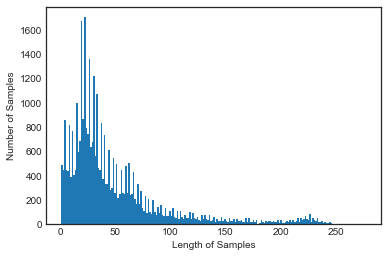

In [18]:
plt.hist([len(s) for s in train], bins=200)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [19]:
max_len = 250

In [20]:
#train을 일정한 길이로 맞춘다(250자 이하)
train = pad_sequences(train, maxlen=max_len)